In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
import sklearn
import email
import re
import plotly.express as px
from difflib import get_close_matches

In [299]:
import os
print(os.getcwd())  # This prints the current directory

C:\Users\lidor\anaconda_projects\email_categorization


In [5]:
!pip install wordcloud

In [301]:
# Adjust the path based on your actual file location
file_path = "../db/emails.csv"

# Load only the first few rows to inspect the structure (avoiding memory issues)
emails = pd.read_csv(file_path, nrows=100)

# Display some sample rows
emails.head()

file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             message  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n   
1  Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: john.lavorato@enron.com\nSubject: Re:\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nTraveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and r

In [9]:
# Check column names, data types, and missing values
df.info()

# Check for null values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     100 non-null    object
 1   message  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


file       0
message    0
dtype: int64

In [303]:
# Show full message content
pd.set_option('display.max_colwidth', None)  # Allow full text display
print(emails.loc[0]['message'])


Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [305]:
# Load CSV file (replace 'emails.csv' with your actual file)
emails = pd.read_csv(file_path)

# Function to parse an email and extract required features
def parse_email(raw_email):
    msg = email.message_from_string(raw_email)
    
    date = msg['Date']
    sender = msg['From']
    recipients = msg['To']
    subject = msg['Subject'] if msg['Subject'] else ""
    
    # Extract body
    body = ""
    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == "text/plain":
                body += part.get_payload(decode=True).decode(errors='ignore')
    else:
        body = msg.get_payload(decode=True).decode(errors='ignore')
    
    content_length = len(body)
    num_recipients = len(recipients.split(",")) if recipients else 0
    
    x_folder = msg['X-Folder'] if 'X-Folder' in msg else "Unknown"
    x_folder = x_folder.split("\\")[-1].lower()  # Extract only the last folder name
    
    return pd.Series([x_folder, date, sender, recipients, subject, body, content_length, num_recipients])

# Apply function to extract features
emails[['X-Folder', 'Date', 'From', 'To', 'Subject', 'Body', 'Content-Length', 'Number of Recipients']] = emails['message'].apply(parse_email)

In [169]:
emails.head()

file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             message  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n    
1  Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: john.lavorato@enron.com\nSubject: Re:\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nTraveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and

In [171]:
# Count emails with 1 recipient vs more than 1 recipient
one_recipient_count = (emails['Number of Recipients'] == 1).sum()
multiple_recipients_count = (emails['Number of Recipients'] > 1).sum()

print("Number of emails with 1 recipient:", one_recipient_count)
print("Number of emails with more than 1 recipient:", multiple_recipients_count)

Number of emails with 1 recipient: 354298
Number of emails with more than 1 recipient: 141256


In [173]:
print(emails["X-Folder"].sample(7))

404357         all documents
93740          all documents
112445              wellhead
444246    discussion threads
46555             'sent mail
357164            sent items
432153         deleted items
Name: X-Folder, dtype: object


In [175]:
# Convert date column to datetime 
emails["Date"] = pd.to_datetime(emails["Date"])
print(emails.iloc[:1]["Date"])

C:\Users\lidor\AppData\Local\Temp\ipykernel_33440\2545605241.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



0    2001-05-14 16:39:00-07:00
Name: Date, dtype: object


C:\Users\lidor\AppData\Local\Temp\ipykernel_33440\2545605241.py:2: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



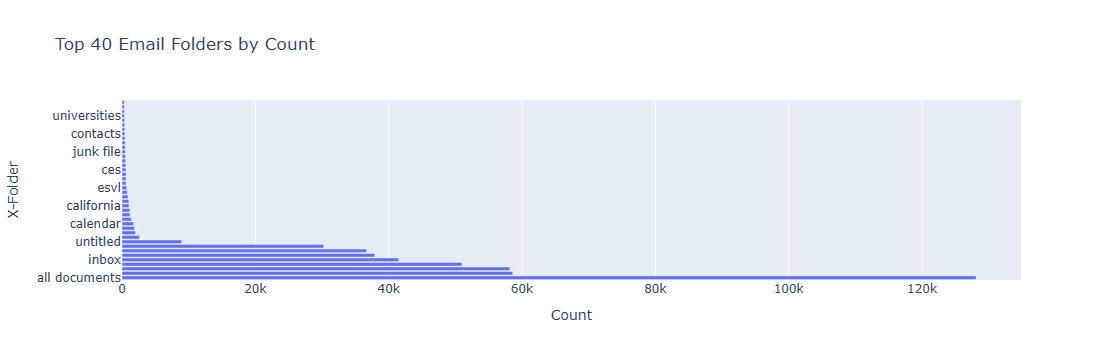

In [177]:
# Visualize folders by size using Plotly
folder_counts = emails['X-Folder'].value_counts().reset_index()
folder_counts.columns = ['X-Folder', 'Count']

fig = px.bar(folder_counts[:40], x='Count', y='X-Folder', orientation='h', title='Top 40 Email Folders by Count')
fig.show()


In [179]:
# Remove generic folders
generic_folders = {"inbox", "sent", "deleted items", "drafts", "all documents", "discussion threads", "'sent mail", "discussion threads", "sent items", 
                  "untitled", "notes inbox", "junk file", "calendar"}
emails = emails[~emails['X-Folder'].isin(generic_folders)]

In [181]:
# Merge similar folder names dynamically
unique_folders = emails['X-Folder'].unique().tolist()
folder_mapping = {}

for folder in unique_folders:
    match = get_close_matches(folder, unique_folders, n=1, cutoff=0.8)  # Adjust cutoff for similarity threshold
    if match and match[0] != folder:
        folder_mapping[folder] = match[0]

In [182]:
emails['X-Folder'] = emails['X-Folder'].replace(folder_mapping)

In [183]:
print(emails['X-Folder'].value_counts())  # Show top 100 folders

X-Folder
personal                 2642
attachments              2026
meetings                 1872
schedule crawler         1398
logistics                1192
                         ... 
republican leadership       1
staff meetings              1
speaking engagements        1
survey                      1
clean fuels                 1
Name: count, Length: 1770, dtype: int64


In [187]:
print(len(emails))

64001


In [229]:
# Count folders dynamically
folder_counts = emails['X-Folder'].value_counts()
for i in range(1, 31):
    count = (folder_counts == i).sum()
    print(f"Folders with exactly {i} emails: {count}")

Folders with exactly 1 emails: 0
Folders with exactly 2 emails: 0
Folders with exactly 3 emails: 0
Folders with exactly 4 emails: 0
Folders with exactly 5 emails: 0
Folders with exactly 6 emails: 0
Folders with exactly 7 emails: 0
Folders with exactly 8 emails: 0
Folders with exactly 9 emails: 0
Folders with exactly 10 emails: 0
Folders with exactly 11 emails: 0
Folders with exactly 12 emails: 0
Folders with exactly 13 emails: 0
Folders with exactly 14 emails: 0
Folders with exactly 15 emails: 0
Folders with exactly 16 emails: 0
Folders with exactly 17 emails: 0
Folders with exactly 18 emails: 0
Folders with exactly 19 emails: 0
Folders with exactly 20 emails: 0
Folders with exactly 21 emails: 0
Folders with exactly 22 emails: 0
Folders with exactly 23 emails: 0
Folders with exactly 24 emails: 0
Folders with exactly 25 emails: 0
Folders with exactly 26 emails: 0
Folders with exactly 27 emails: 0
Folders with exactly 28 emails: 0
Folders with exactly 29 emails: 0
Folders with exactly 30

In [231]:
small_folders = folder_counts[folder_counts.between(1, 30)].index.tolist()
emails = emails[~emails['X-Folder'].isin(small_folders)]

In [249]:
# Merge specified similar folder names
merge_folders = {
    "personnel": "personal",
    "personalfolder": "personal",
    "personal mail": "personal",
    "personal stuff": "personal",
    "personnal": "personal",
    "human resources": "hr",
    "netco hr": "hr",
    "resumes": "hr",
    
}
emails['X-Folder'] = emails['X-Folder'].replace(merge_folders)


In [257]:
# Sort folders in ascending order
emails = emails.sort_values(by=['X-Folder'])

In [279]:
folders_to_count = [
    "california", "california issues", "europe", "mexico", "australia", "canada", "japan", "portland", 
    "london", "india", "california - working group", "florida", "denver", "stanford", "alaska gas", "texas", 
    "california crisis--press", "california legal issues", "west-bank", "south america", "portland general", 
    "caliornia - investigations", "brazil", "texas b-school"
]

folder_counts = emails['X-Folder'].value_counts()

# Filter only the specified folders and print counts
for folder in folders_to_count:
    print(f"{folder}: {folder_counts.get(folder, 0)} emails")

total_count = emails['X-Folder'].value_counts().loc[folders_to_count].sum()
print(f"Total emails in specified folders: {total_count}")

emails = emails[~emails['X-Folder'].isin(folders_to_count)]
print("Specified folders removed.")

california: 0 emails
california issues: 0 emails
europe: 0 emails
mexico: 0 emails
australia: 0 emails
canada: 0 emails
japan: 0 emails
portland: 0 emails
london: 0 emails
india: 0 emails
california - working group: 0 emails
florida: 0 emails
denver: 0 emails
stanford: 0 emails
alaska gas: 0 emails
texas: 0 emails
california crisis--press: 0 emails
california legal issues: 0 emails
west-bank: 0 emails
south america: 0 emails
portland general: 0 emails
caliornia - investigations: 0 emails
brazil: 0 emails
texas b-school: 0 emails


KeyError: "None of [Index(['california', 'california issues', 'europe', 'mexico', 'australia',\n       'canada', 'japan', 'portland', 'london', 'india',\n       'california - working group', 'florida', 'denver', 'stanford',\n       'alaska gas', 'texas', 'california crisis--press',\n       'california legal issues', 'west-bank', 'south america',\n       'portland general', 'caliornia - investigations', 'brazil',\n       'texas b-school'],\n      dtype='object', name='X-Folder')] are in the [index]"

In [295]:
print(emails['X-Folder'].value_counts())
print(emails['X-Folder'].nunique())

X-Folder
personal                            3112
attachments                         2026
meetings                            1872
schedule crawler                    1398
logistics                           1192
hr                                  1168
tw-commercial group                 1159
bill williams iii                   1022
deal discrepancies                   897
management                           802
esvl                                 715
e-mail bin                           614
tufco                                609
ces                                  576
online trading                       573
junk                                 560
ooc                                  511
genco-jv_ipo                         486
projects                             468
archives                             448
contacts                             437
corporate                            421
it                                   369
universities                         367
iso_ pr

In [283]:
# Ensure all rows are printed without truncation
pd.set_option('display.max_rows', None)
print(len(emails))
print(emails['X-Folder'].value_counts().sort_index())

49996
X-Folder
'sent                                265
05-saved                              64
06-saved                             113
07-saved                              98
08-saved                              34
09-saved                              42
10 fantasy                            46
10-saved                              89
11_99                                 53
1_00                                  32
2000 year end                         36
2001/07                               53
2001/08                               59
2001/10                               36
2001/11                               69
2002 budget                           55
24 hour                              229
24-hr power                           53
5_00                                 154
6_00                                 131
6day                                  50
7_00                                 139
8_00                                 210
9_00                                 131
_

In [24]:
import re

def extract_metadata(text, field):
    match = re.search(fr"{field}: (.+)", text)
    return match.group(1).strip() if match else None

# Create new columns from the message content
df['Message-ID'] = df['message'].apply(lambda x: extract_metadata(x, 'Message-ID'))
df['Date'] = df['message'].apply(lambda x: extract_metadata(x, 'Date'))
df['From'] = df['message'].apply(lambda x: extract_metadata(x, 'From'))
df['To'] = df['message'].apply(lambda x: extract_metadata(x, 'To'))
df['Subject'] = df['message'].apply(lambda x: extract_metadata(x, 'Subject'))

# Show the extracted fields
df[['Date', 'From', 'To', 'Subject']].head(10)


Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   
5  Thu, 31 Aug 2000 04:17:00 -0700 (PDT)  phillip.allen@enron.com   
6  Tue, 22 Aug 2000 07:44:00 -0700 (PDT)  phillip.allen@enron.com   
7  Fri, 14 Jul 2000 06:59:00 -0700 (PDT)  phillip.allen@enron.com   
8  Tue, 17 Oct 2000 02:26:00 -0700 (PDT)  phillip.allen@enron.com   
9  Mon, 16 Oct 2000 06:44:00 -0700 (PDT)  phillip.allen@enron.com   

                                                 To  \
0                              tim.belden@enron.com   
1                           john.lavorato@enron.com   
2                            leah.arsdall@enron.com   
3                             randall.gay@enron.com   
4                              greg.piper@enron.com   
5                              greg.piper@enron.com   
6  david.l.johnson@enron.com, john.shafer@enron.com   
7                          joyce.teixeira@enron.com   
8                              mark.scott@enron.com   
9                                   zimam@enron.com   

                                                   Subject  
0                                                     None  
1                                                      Re:  
2                                                 Re: test  
3                                                     None  
4                                                Re: Hello  
5                                                Re: Hello  
6                                                     None  
7                             Re: PRC review - phone calls  
8                           Re: High Speed Internet Access  
9  FW: fixed forward or other Collar floor gas price terms

In [80]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce')
df['Date'].head()

0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: Date, dtype: datetime64[ns]

In [32]:
import matplotlib.pyplot as plt

# Convert date column again in case it's not in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Plot email frequency over time
df.set_index('Date').resample('ME').size().plot(kind='line', figsize=(12,6), title="Emails Sent Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Emails")
plt.show()

In [68]:
df = pd.read_csv(file_path)  # Load full dataset

In [132]:
chunk_size = 10000  # Adjust based on memory capacity

# Create an empty list to store processed chunks
processed_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Extract metadata
    chunk['Message-ID'] = chunk['message'].apply(lambda x: extract_metadata(x, 'Message-ID'))
    chunk['Date'] = chunk['message'].apply(lambda x: extract_metadata(x, 'Date'))
    chunk['From'] = chunk['message'].apply(lambda x: extract_metadata(x, 'From'))
    chunk['To'] = chunk['message'].apply(lambda x: extract_metadata(x, 'To'))
    chunk['Subject'] = chunk['message'].apply(lambda x: extract_metadata(x, 'Subject'))
    
    # Append processed chunk to list
    processed_chunks.append(chunk)

# Combine all processed chunks into a single DataFrame
df = pd.concat(processed_chunks, ignore_index=True)

# Save processed dataset for faster access later
df.to_csv("processed_emails.csv", index=False)

# Show the extracted fields
df[['Date', 'From', 'To', 'Subject']].head(10)

Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   
5  Thu, 31 Aug 2000 04:17:00 -0700 (PDT)  phillip.allen@enron.com   
6  Tue, 22 Aug 2000 07:44:00 -0700 (PDT)  phillip.allen@enron.com   
7  Fri, 14 Jul 2000 06:59:00 -0700 (PDT)  phillip.allen@enron.com   
8  Tue, 17 Oct 2000 02:26:00 -0700 (PDT)  phillip.allen@enron.com   
9  Mon, 16 Oct 2000 06:44:00 -0700 (PDT)  phillip.allen@enron.com   

                                                 To  \
0                              tim.belden@enron.com   
1                           john.lavorato@enron.com   
2                            leah.arsdall@enron.com   
3                             randall.gay@enron.com   
4                              greg.piper@enron.com   
5                              greg.piper@enron.com   
6  david.l.johnson@enron.com, john.shafer@enron.com   
7                          joyce.teixeira@enron.com   
8                              mark.scott@enron.com   
9                                   zimam@enron.com   

                                                   Subject  
0                                                     None  
1                                                      Re:  
2                                                 Re: test  
3                                                     None  
4                                                Re: Hello  
5                                                Re: Hello  
6                                                     None  
7                             Re: PRC review - phone calls  
8                           Re: High Speed Internet Access  
9  FW: fixed forward or other Collar floor gas price terms

In [166]:
df['Date'] = pd.to_datetime(
    df['Date'].str.extract(r'^(.*? -\d{4})', expand=False),  # Extract up to timezone offset
    format='%a, %d %b %Y %H:%M:%S %z',  # Define the format including timezone
    errors='coerce'  # Gracefully handle parsing errors
)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(df['Date'].isna().sum())  # Count NaT values
print(df['Date'].dtype)         # Check datatype
print(df['Date'].head(10))      # Preview first 10 values

239746
datetime64[ns, UTC-07:00]
1    2001-05-04 13:51:00-07:00
2    2000-10-18 03:00:00-07:00
4    2000-08-31 05:07:00-07:00
5    2000-08-31 04:17:00-07:00
7    2000-07-14 06:59:00-07:00
8    2000-10-17 02:26:00-07:00
9    2000-10-16 06:44:00-07:00
10   2000-10-16 06:42:00-07:00
12   2000-10-09 07:16:00-07:00
13   2000-10-09 07:00:00-07:00
Name: Date, dtype: datetime64[ns, UTC-07:00]


C:\Users\lidor\AppData\Local\Temp\ipykernel_18728\2677828491.py:1: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



In [60]:
print(df.columns)  # Check if "Date" exists
print(df.head())  # Preview the first few rows
print(df['Date'].dtype)  # See the data type of "Date"

Index(['file', 'message', 'Message-ID', 'Date', 'From', 'To', 'Subject'], dtype='object')
                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [128]:
# Drop rows where 'Date' is NaT
df = df.dropna(subset=['Date'])

In [130]:
df.set_index('Date').resample('ME').size().plot(
    kind='line', figsize=(12,6), title="Emails Sent Over Time"
)
plt.xlabel("Date")
plt.ylabel("Number of Emails")
plt.show()

In [146]:
import plotly.express as px

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lidor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


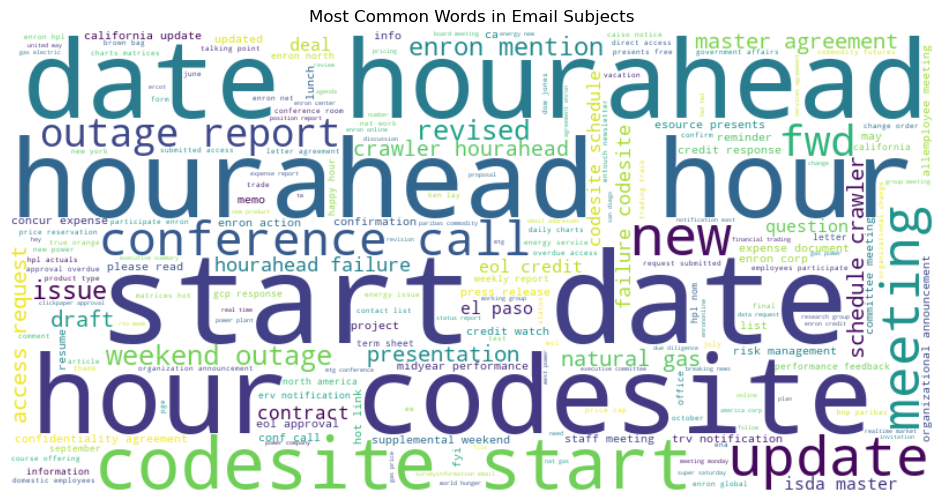

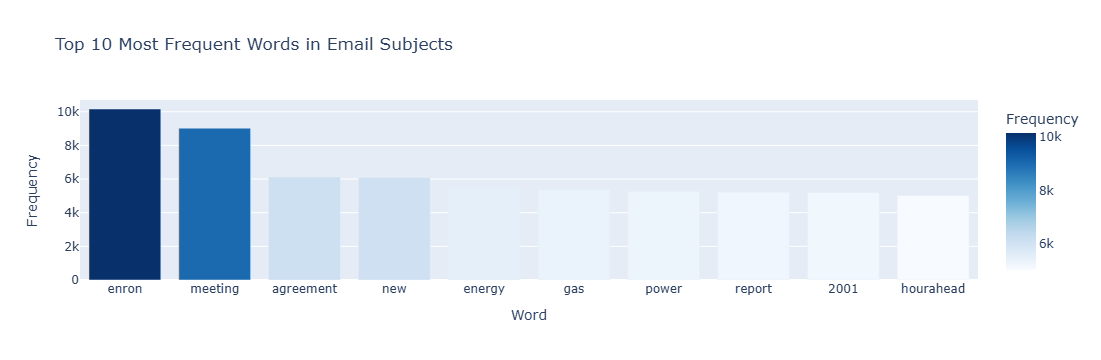

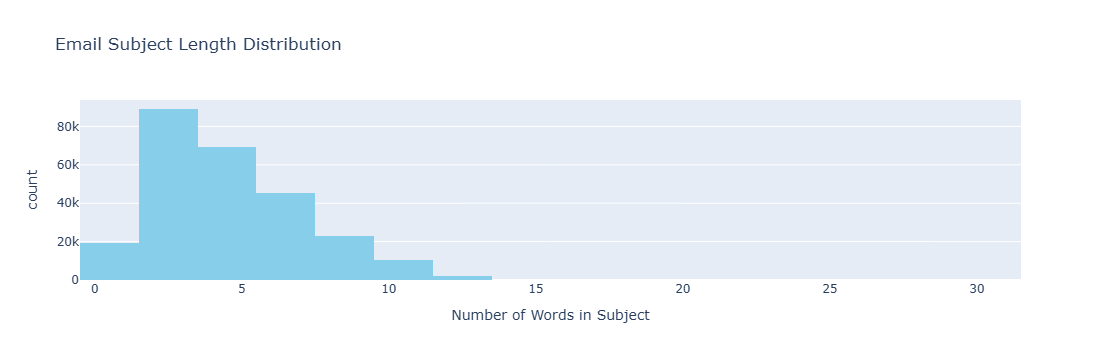

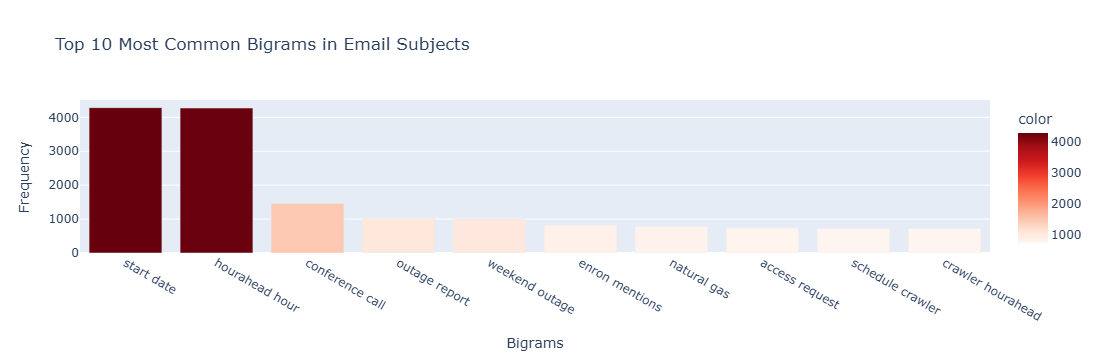

C:\Users\lidor\AppData\Local\Temp\ipykernel_18728\3893275185.py:82: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



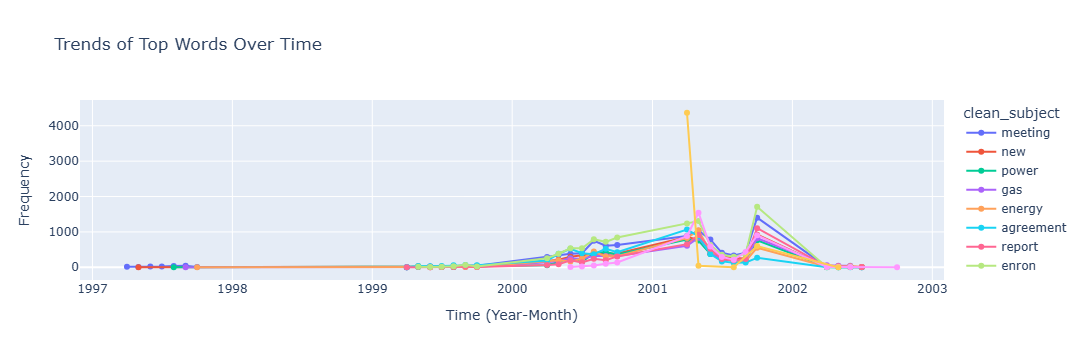

In [170]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
from collections import Counter
from itertools import islice
from nltk.util import ngrams

# Ensure stopwords are available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add additional common words to remove
custom_stopwords = set(["re", "fw", "subject", "hi", "hello", "thanks", "regards"]) 
stop_words.update(custom_stopwords)

# Load dataset (assuming df is already loaded)
df = df.dropna(subset=['Subject'])  # Remove NaN subjects

# Preprocess subjects
def preprocess_subject(subject):
    if not isinstance(subject, str):  # Ensure subject is a string
        subject = str(subject)
    subject = subject.lower()  # Convert to lowercase
    subject = subject.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = subject.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

df['clean_subject'] = df['Subject'].apply(preprocess_subject)

# Generate word cloud
text = ' '.join([' '.join(words) for words in df['clean_subject']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Email Subjects')
plt.show()

# Generate bar chart of top N frequent words
N = 10  # Change this value to adjust the number of top words
word_list = [word for words in df['clean_subject'] for word in words]
word_counts = Counter(word_list).most_common(N)

# Create DataFrame from word counts
df_words = pd.DataFrame(word_counts, columns=['Word', 'Frequency'])

# Create bar chart with Plotly
fig = px.bar(df_words, x='Word', y='Frequency', title=f'Top {N} Most Frequent Words in Email Subjects',
             color='Frequency', color_continuous_scale='blues')

# Show interactive plot
fig.show()

# Subject length distribution
df['subject_length'] = df['Subject'].apply(lambda x: len(x.split()))
fig = px.histogram(df, x='subject_length', nbins=30, title='Email Subject Length Distribution', labels={'subject_length': 'Number of Words in Subject', 'count': 'Frequency'}, color_discrete_sequence=['skyblue'])
fig.show()

# Extract bigrams and trigrams
def get_ngrams(words_list, n):
    return [' '.join(gram) for words in words_list for gram in ngrams(words, n)]

bigram_counts = Counter(get_ngrams(df['clean_subject'], 2)).most_common(10)
trigram_counts = Counter(get_ngrams(df['clean_subject'], 3)).most_common(10)

# Visualize bigrams
bigram_words, bigram_freqs = zip(*bigram_counts)
fig = px.bar(x=bigram_words, y=bigram_freqs, labels={'x': 'Bigrams', 'y': 'Frequency'}, title='Top 10 Most Common Bigrams in Email Subjects', color=bigram_freqs, color_continuous_scale='Reds')
fig.show()

# Visualize trigrams
trigram_words, trigram_freqs = zip(*trigram_counts)
fig = px.bar(x=trigram_words, y=trigram_freqs, labels={'x': 'Trigrams', 'y': 'Frequency'}, title='Top 10 Most Common Trigrams in Email Subjects', color=trigram_freqs, color_continuous_scale='Greens')
fig.show()

# Trends over time for top words

# Trends over time for top words
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)
trend_data = df.explode('clean_subject')
top_words = [word for word, _ in word_counts]
trend_data = trend_data[trend_data['clean_subject'].isin(top_words)]
trend_counts = trend_data.groupby(['YearMonth', 'clean_subject']).size().reset_index(name='Count')

fig = px.line(trend_counts, x='YearMonth', y='Count', color='clean_subject', markers=True, title='Trends of Top Words Over Time', labels={'YearMonth': 'Time (Year-Month)', 'Count': 'Frequency'})
fig.show()